#### Notebook includes



- Notebook purpose description
- Data loading
- Training, validation, and test data set-up
- Volve 2011 and 2009 source data comparison
- Data Preprocessing
- Model set up
- Start training
- Inferences and predicitons

#### Notebook purpose

In this Notebook trained model is used to make predictions on the partial seismics extracted from the Volve ST10010ZC11 vintage. Note: model was trained on an older ST0202R08 vintage. Model is trained on the older seimic data and all the relevant comments are preserved.

The objective is to use newer vintage for the testing, since we want to compare our results to Ravasi's who's used ST10010ZC11 survey.

In [3]:
import sys
import yaml 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
from tensorflow import keras
import numpy as np
import os
sys.path.append('../')
from sklearn.preprocessing import RobustScaler
from utils.plotting_utils import plot_wells_dataset_in_map
from models.models import MyModel
from utils.seis_utils import batch_trace_attributes, seismic_attribute
from utils.utils import limit_gpu_memory_for_process
from train.preprocessing import create_dataset
import geopandas as gpd
%matplotlib inline


import seaborn as sns
import xarray as xr 
sns.set()

In this notebook we will train a TCN model with the aim to predict Acoustic impedance from the seismic traces. 
The aim of the model is to map a relationship of the seismic traces for different partial stacks and their corresponding seismic attributes. For simplification, we will just look at the envelope of each trace.

The model will be constrained to be trained and predict on the Lista and Heimdal Formations. 

First, we want to set up the different training parameters, training data, as well as the validation and test for this experiment. All this setup is describe in a config.yaml file.  

In [4]:
output_dir = '../tests/baseline/zp0/' 

yaml_path = output_dir+'config.yaml'
f = open(yaml_path, 'r')
config = yaml.load(f, Loader=yaml.Loader)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

limit_gpu_memory_for_process(0.3)

2022-08-09 12:47:18.727618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 12:47:19.181339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3353 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1


In [5]:
for k,v in config.items():
    print({k:v})

{'data_file': ['../data/well_seismics/well_logs_torolfv3_with_seismic1ms.csv']}
{'model': {'model': 'TCN', 'filters': 128}}
{'features': ['twt', 'seis_near', 'seis_nearmid', 'seis_mid', 'seis_far', 'formations']}
{'targets': ['zp']}
{'seismic_attributes': ['envelope', 'phase', 'cosine_of_phase']}
{'formations': ['LISTA FM', 'HEIMDAL FM']}
{'train': {'lr': 0.0001, 'epochs': 200}}
{'data': {'train': {'well_names': ['15/9-F-1 A', '15/9-19 A', '15/9-F-1 C', '15/9-F-1', '15/9-F-11 B', '15/9-F-11 T2', '15/9-F-12', '15/9-F-14', '15/9-F-15 D', '15/9-F-5', '15/9-19 BT2']}, 'val': {'well_names': ['15/9-F-4']}, 'test': {'well_names': ['15/9-F-15 A']}}}


In [6]:
data_file = config['data_file'][0]
formations = config['formations']
data = config['data']
wells_train = data['train']['well_names']
wells_val = data['val']['well_names']
wells_test = data['test']['well_names']
features = config['features']
targets = config['targets']
seismic_attributes = config['seismic_attributes']
used_wells = wells_train+wells_val+wells_test

# Load Data

We load the well-seimic data derived from both ST10010ZC11 and ST0202R08 seismic vintages. The model is trained on an older one, while we are trying to predict on a newer seismic survey data.



In [7]:
survey = gpd.read_file('../data/Shapefiles/seismic.shp') # Layout of the survey 

well_datac=pd.read_csv(data_file)
#well_datac['seis_grad'] = well_datac['seis_far']-well_datac['seis_near']

well_datac = well_datac.loc[well_datac.well.isin(used_wells)]

well_datac.twt

test = ['15/9-F-15 A']

well_datac_test = pd.read_csv('../data/well_seismics/well_logs_torolfv3_with_new_seismic1ms.csv')
well_datac_test = well_datac_test.loc[well_datac_test.well.isin(test)]

The following map is an overview of the training,validation and test wells. The position of the well is the mean X,Y UTM location at the interval of study (Lista and Heimdal)

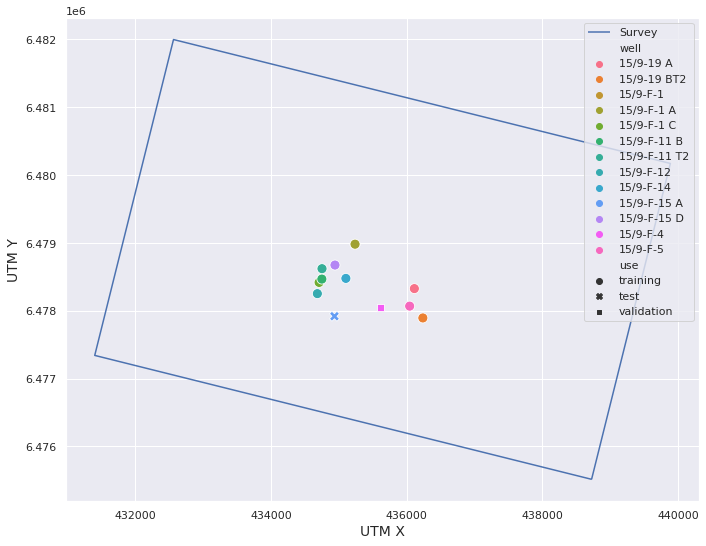

In [10]:
avg_position = well_datac.loc[well_datac.formations.isin(formations)].groupby('well')[['x','y']].mean().copy()
f = plot_wells_dataset_in_map(avg_position,survey,wells_train,wells_val,wells_test,path=output_dir+'map.png')

Since we want to be consistent with the partial seismic names, below we rename the 2011 seismic vintage columns

In [14]:
well_datac_test.rename(columns={'far_seis': 'seis_far', 'mid_seis': 'seis_mid', 'near_seis':'seis_near', 'near_mid_seis': 'seis_nearmid'}, inplace=True)
well_datac

well_datac_test.columns

Index(['gr', 'rdep', 'den', 'ac', 'den_pred', 'ac_pred', 'acs_pred',
       'den_join', 'ac_join', 'acs_join', 'vsh', 'phit', 'phie', 'swe', 'md',
       'vp_original', 'density_original', 'zp_original', 'vp', 'vs', 'rho',
       'zp', 'zs', 'vpvs', 'x', 'y', 'z', 'tvd', 'dx', 'dy', 'azim_tn', 'incl',
       'dls', 'azim_gn', 'tvd_msl', 'md_msl', 'il', 'xl', 'il_sample',
       'xl_sample', 'twt_vsp', 'seis_far', 'seis_mid', 'seis_nearmid',
       'seis_near', 'twt', 'well', 'acs', 'vs_original', 'zs_original',
       'vpvs_original', 'twt_funct', 'formations'],
      dtype='object')

#### Training, validation, and test data set-up

In [15]:
well_datac.set_index(['well'], inplace=True)
well_datac = well_datac.loc[well_datac['formations'].isin(formations)]

data = well_datac.copy()
data.dropna(axis=0,how='all',inplace=True,subset=targets) 

logs = set(features + targets + ['formations','gr','twt'])
well_datac = well_datac[logs]
well_datac.dropna(inplace=True)


# Store validation and test original data. 
dv = well_datac.loc[wells_val].copy().reset_index() 
# dt = well_datac.loc[wells_test].copy().reset_index()

# ### test
well_datac_test.set_index(['well'], inplace=True)
well_datac_test = well_datac_test.loc[well_datac_test['formations'].isin(formations)]

data_test = well_datac_test.copy()
data_test.dropna(axis=0,how='all',inplace=True,subset=targets) 

logs_test = set(features + targets + ['formations','gr','twt'])
well_datac_test = well_datac_test[logs]
well_datac_test.dropna(inplace=True)


# Store validation and test original data. 
# dv_test = well_datac_test.loc[wells_val].copy().reset_index() 
dt_test = well_datac_test.loc[wells_test].copy().reset_index()

#### Volve 2011 and 2009 source data comparison


We want to compare Volve 2009 and 2011 seismic data and log data to make sure that they are within the same ranges

In [17]:
well_datac_f15 = well_datac.loc[well_datac.index.isin(['15/9-F-15 A'])]
well_datac_test_f15 = well_datac_test.loc[well_datac_test.index.isin(['15/9-F-15 A'])]

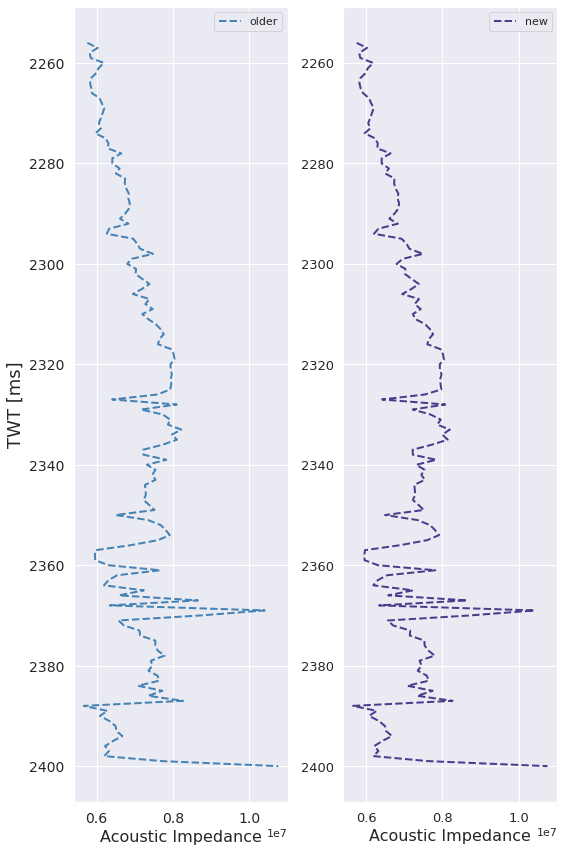

In [18]:
# Subplot if we need to do side by side

fig,ax = plt.subplots(figsize=(8,12),ncols=2) 

ax[0].plot(well_datac_f15.zp, well_datac_f15.twt , 'steelblue',lw=2, ls = '--', label = 'older')

ax[0].legend(loc = 'upper right')

ax[1].plot(well_datac_test_f15.zp, well_datac_test_f15.twt,color='darkslateblue',lw=2, ls = '--',alpha=1, label = 'new')
ax[1].legend(loc = 'best')


# ax[0].set_ylim([2330, 2500])

ax[0].invert_yaxis()
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel('Acoustic Impedance', fontsize=16)
ax[0].set_ylabel('TWT [ms]', fontsize=18)



#
ax[1].invert_yaxis()
ax[1].set_xlabel('Acoustic Impedance', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)


plt.rc('legend',fontsize=14)
# plt.gca().invert_yaxis()

# fig.suptitle('Ragnarock AI measured/Das ', y = 1, fontsize = 16)


plt.tight_layout()




We make sure that acoustic impedance is within the same range of the values. Thus, acoustic impedance shouldn't cause an important difference in the predictions. Below one can find histograms of the partial seismic values colored by the survey.

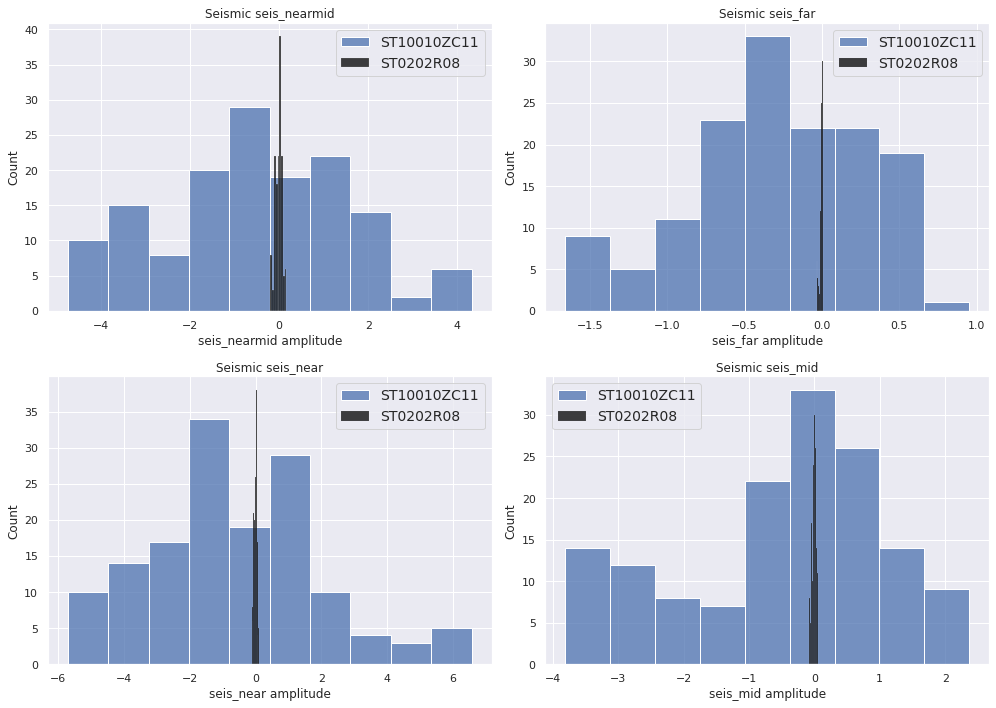

In [23]:
#  Categorical Data
seis = ['seis_nearmid', 'seis_far','seis_near', 'seis_mid']

#  Categorical Data
a = 2  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,10))

for i in seis:
    plt.subplot(a, b, c)
    plt.title('Seismic {}'.format(i))
    plt.xlabel(f'{i} amplitude')
    sns.histplot(well_datac_test_f15[i], label = 'ST10010ZC11')
    sns.histplot(well_datac_f15[i], color = 'black', label = 'ST0202R08')

    # sns.histplot(data = result, x = i, color = 'blue', label = 'newer vintage', hue = 'vintage')
    plt.legend()


    c = c + 1

plt.tight_layout()

We can clearly observe the difference between the stacks. Since partial stacks are the part the features to be used for predictions, we expect results not to be be out of range.

# Data Preprocessing

Now, we will split the data between training, validation and test datasets. 

- dataset_train: Here we select the training wells that will be used for this experiment. We generate the trace attributes, and do the feature scaling/normalization. 

- dataset_val,dataset_test: We select the corresponding wells, select the features and calculate the trace attributes. After that, we transform the features using the scaling/normalization from the training data. 


We can access the data in a different sort of ways. However, the most important method for this class is 'data_generator'. It allows us to access the (features,targets) pair for each well. The generators will be use during training to ensured that the model just sees data of one well at the time. 



In [24]:
well_datac.twt

well
15/9-19 A    2267.0
15/9-19 A    2268.0
15/9-19 A    2269.0
15/9-19 A    2270.0
15/9-19 A    2271.0
              ...  
15/9-F-5     2372.0
15/9-F-5     2373.0
15/9-F-5     2374.0
15/9-F-5     2375.0
15/9-F-5     2376.0
Name: twt, Length: 1820, dtype: float64

train and validation data created is based on an older vintage. Test set is the only one that use newer seismic vintage, and will be used to test the predictions

In [25]:
# set up training and validation dataset

dataset_train = create_dataset(well_datac,well_names=wells_train,
                              features=features,targets=targets,scaler_name='RobustScaler',
                              seismic_attributes=seismic_attributes,
                              output_dir=output_dir)

dataset_val = create_dataset(well_datac,well_names=wells_val,
                            seismic_attributes=seismic_attributes,
                            scaler_path=output_dir+'/scaler.joblib',
                            features=features,targets=targets)

dataset_test = create_dataset(well_datac_test,well_names=wells_test,
                            seismic_attributes=seismic_attributes,
                            scaler_path=output_dir+'/scaler.joblib',
                            features=features,targets=targets)

scaler is loaded from ../tests/baseline/zp0//scaler.joblib
scaler is loaded from ../tests/baseline/zp0//scaler.joblib


Since we apply seismic attributes, we added new features

In [26]:
features = dataset_train.features 
len_features = len(features)
len_targets = len(targets)
print(f'We have {len_features}: {features}')

We have 18: ['twt', 'seis_near', 'seis_nearmid', 'seis_mid', 'seis_far', 'seis_near_envelope', 'seis_near_phase', 'seis_near_cosine_of_phase', 'seis_nearmid_envelope', 'seis_nearmid_phase', 'seis_nearmid_cosine_of_phase', 'seis_mid_envelope', 'seis_mid_phase', 'seis_mid_cosine_of_phase', 'seis_far_envelope', 'seis_far_phase', 'seis_far_cosine_of_phase', 'fm_code']


In [27]:
training_gen = dataset_train.data_generator()
val_gen = dataset_val.data_generator()
# Since we just have one well for validation and one for testing, we do not use the generator for these datasets

X_val_scaled = dataset_val.X_scaled.values
y_val_scaled = dataset_val.Y_scaled.values

X_test_scaled = dataset_test.X_scaled.values
y_test_scaled = dataset_test.Y_scaled.values

# We reshape these arrays in order to be ingested by the model

X_val_scaled  = X_val_scaled.reshape(-1, 1, len(features))
X_test_scaled  = X_test_scaled.reshape(-1, 1, len(features))
y_val_scaled = y_val_scaled.reshape(-1, 1, len(targets))
y_test_scaled = y_test_scaled.reshape(-1, 1, len(targets))

In [63]:
X_test_scaled.shape

(145, 1, 18)

# Model Set up

In [28]:
# set loss and metrics
lr = config['train']['lr']
optim = keras.optimizers.Adam(learning_rate=lr)

# set loss and metrics 
mse = keras.losses.MeanSquaredError(name="mse")
mae = keras.metrics.MeanAbsoluteError(name="mae")
# set callbacks

callbacks = [
    K.callbacks.EarlyStopping(monitor="val_mae", patience=10),
    K.callbacks.ModelCheckpoint(output_dir,
                                    monitor="val_mae",
                                    save_best_only=True,
                                    mode="min"),
    ]


# start training 
epochs = config['train']['epochs']

model_name = config['model']['model']
model_filters = config['model']['filters']

#model_name = 'CLSTM_D0'
steps_per_epoch = len(wells_train)
m = MyModel(model_name,model_filters,input_shape=(1,len_features),units=len_targets)
m.model.compile(optimizer=optim, loss=mse, metrics=[mae])


# Lets print the parameters for the training and model

for field in ['train','model']:
    for k,v in config[field].items():
        print(k,v)

2022-08-08 17:24:04.970177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3353 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1


lr 0.0001
epochs 200
model TCN
filters 128


filters = [16,32,64,128]
models_evaluation = {}
for i,f in enumerate(filters):
    m = MyModel(model_name,f,input_shape=(1,len_features),units=len_targets)
    m.model.compile(optimizer=optim, loss=mse, metrics=[mae])
    history = m.model.fit(training_gen, epochs=epochs, validation_data=val_gen,
                    callbacks=callbacks,steps_per_epoch=steps_per_epoch,
                    validation_steps=len(wells_val),verbose=0)
    evaluation = m.model.evaluate(X_test_scaled,y_test_scaled)[1]
    models_evaluation.update({f:evaluation})

# Start training

2022-08-08 17:24:09.554268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-08-08 17:24:09.736024: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-08 17:24:10.190448: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


INFO:tensorflow:Assets written to: ../tests/baseline/zp0/assets


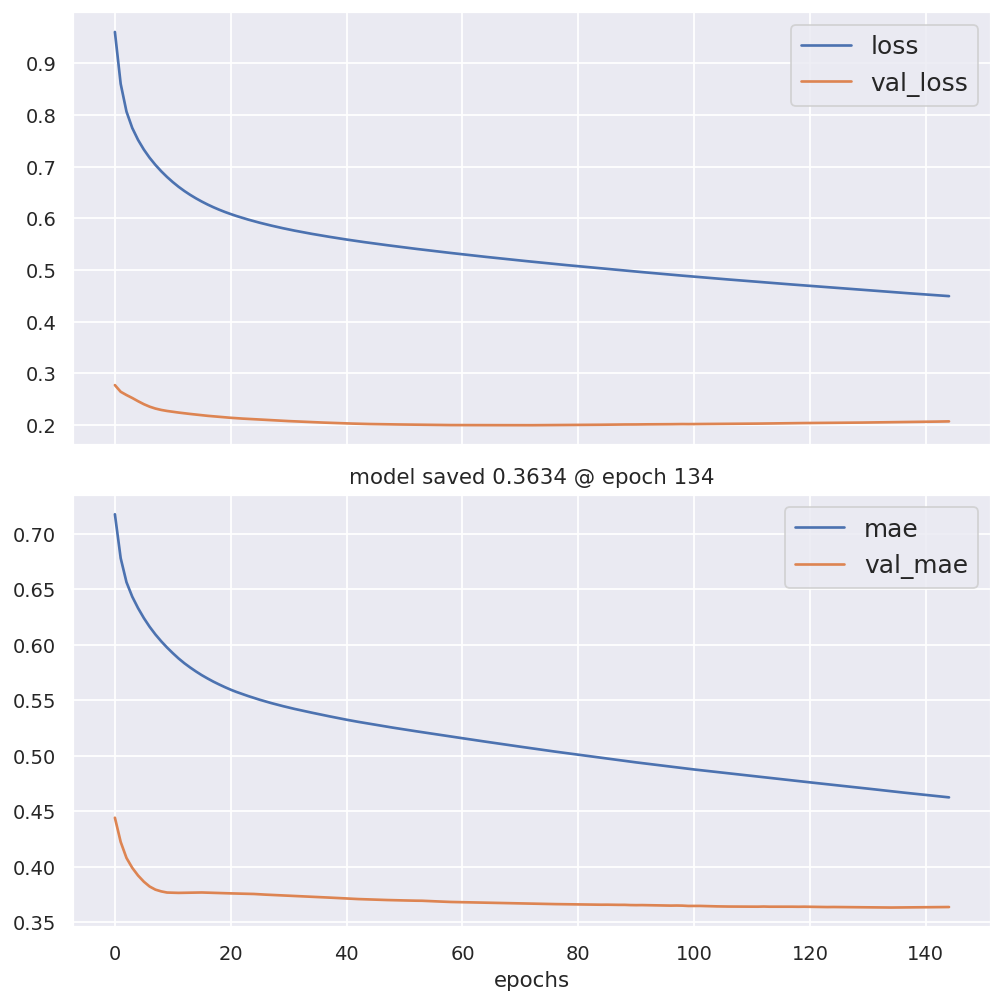

In [29]:
m_filter = 128
m = MyModel(model_name,m_filter,input_shape=(1,len_features),units=len_targets)
m.model.compile(optimizer=optim, loss=mse, metrics=[mae])
history = m.model.fit(training_gen, epochs=epochs, validation_data=val_gen,
                    callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=len(wells_val),
                    verbose=0)


# saving loss history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(output_dir + 'history.csv')

# saving loss history plots
fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=128, sharex=True)
hist_df[['loss', 'val_loss']].plot(ax=axes[0])
hist_df[['mae', 'val_mae']].plot(ax=axes[1])
axes[1].set_xlabel('epochs')
axes[1].set_title(
    f"model saved {hist_df['val_mae'].min():.4} @ epoch {hist_df['val_mae'].argmin()}"
)
fig.tight_layout()
fig.savefig(output_dir + "losses.png")


In [66]:
m.model.evaluate(X_test_scaled,y_test_scaled)

5/5 [==============================] - 0s 10ms/step - loss: 136.3707 - mae: 8.8399


[136.37071228027344, 8.839871406555176]

In comparison with the results when we use the older vintage, as per our expecations the results have deterioated.

# Inference

First thing we need to do is get the scaler that was used to transform the data. We will predict using the model, and the transform the predictions to the actual values

In [31]:
subset_scaler = dataset_train.transformer
idxs = [subset_scaler.get_feature_names_out().tolist().index(n) for n in targets]
subset_scaler.center_ = subset_scaler.center_[idxs]
subset_scaler.scale_ = subset_scaler.scale_[idxs]

### Predict

In [32]:
# Validation Well
pred_scaled = m.model.predict(X_val_scaled)
temp1 = pred_scaled.reshape((pred_scaled.shape[0], len_targets))
pred = subset_scaler.inverse_transform(temp1)
pred = np.array(pred)
twts_preds = well_datac.loc[wells_val[0]].twt.values
wells_val_name = [wells_val[0].replace('/','_')]
validation = np.array([twts_preds,pred.reshape(-1)])
np.save(output_dir+f'Validation_{wells_val_name[0]}_{targets[0]}.npy',validation)

# Test Well
pred_scaled_test = m.model.predict(X_test_scaled)
temp_test = pred_scaled_test.reshape((pred_scaled_test.shape[0], len_targets))
pred_test = subset_scaler.inverse_transform(temp_test)
pred_test = np.array(pred_test)
# twts_preds_test = dataset_test.X_scaled.index.get_level_values(1)
twts_preds_test = well_datac.loc[wells_test[0]].twt.values
wells_test_name = [wells_test[0].replace('/','_')]
test = np.array([twts_preds_test,pred_test.reshape(-1)])
np.save(output_dir+f'Blind_{wells_test_name[0]}_{targets[0]}.npy',test)

5/5 [==============================] - 0s 9ms/step


Validation well and test (blind) well correlation with original measured data is respectively equal to [0.24546885], [-114.9676018]


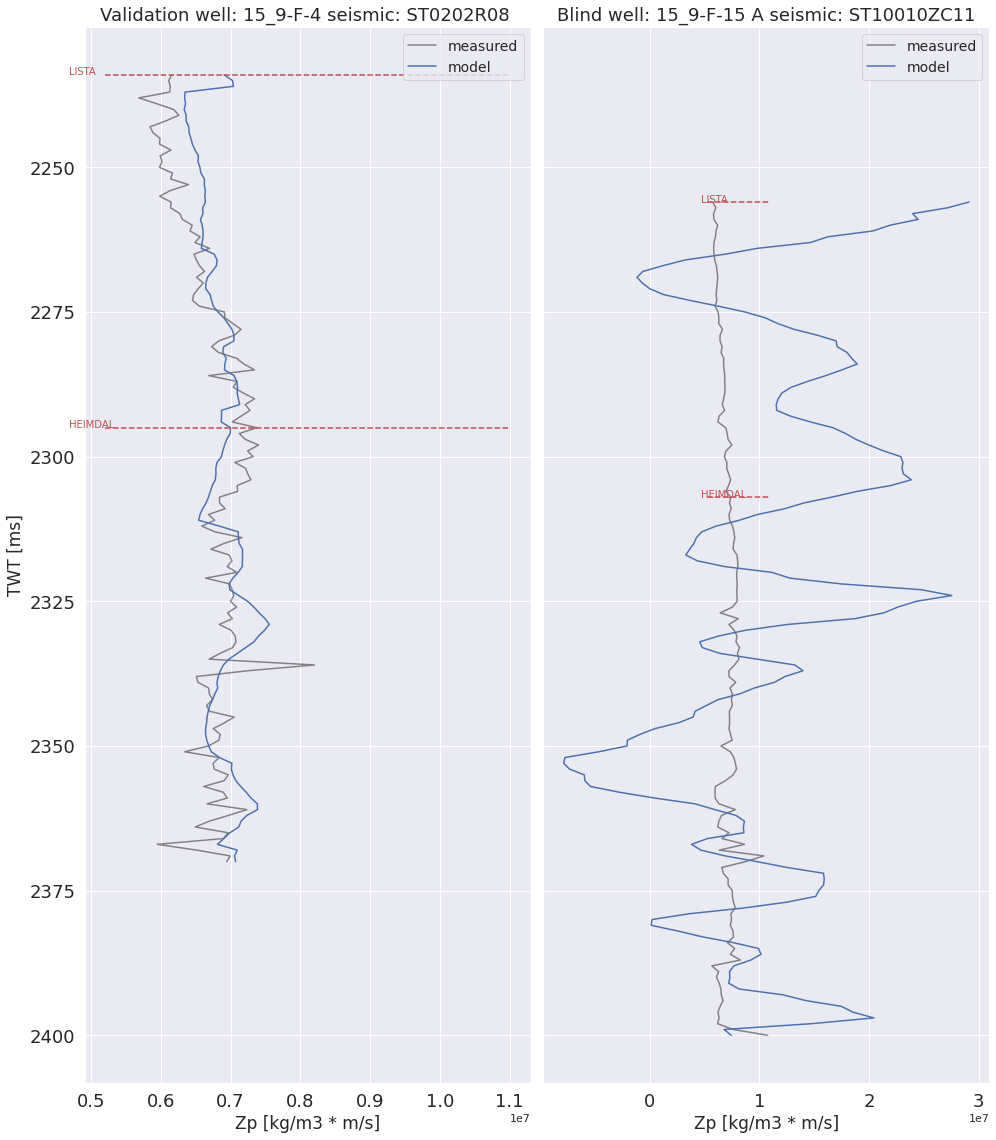

In [50]:
def correlation (x,y):

        #correlation
    x = x.to_numpy()
    y = y.flatten()


    x_mean = np.mean(x, axis=-1, keepdims=True)
    y_mean = np.mean(y, axis=-1, keepdims=True)
    x_std = np.std(x, axis=-1, keepdims=True)
    y_std = np.std(y, axis=-1, keepdims=True)

    #coefficeint of determination (r2)
    S_tot = np.sum((x-x_mean)**2, axis=-1, keepdims=True)
    S_res = np.sum((x - y)**2, axis=-1, keepdims=True)

    r2 = (1-S_res/S_tot)
    return r2

fig,ax = plt.subplots(ncols=2,nrows=len_targets,sharey=True,figsize=(14,16))
xmin,xmax = data[targets].describe().loc[['min','max']].values

if len_targets > 1:

    for i,tar in enumerate(targets):
        ax[0,0].set_title(f'Validation: {wells_val_name[0]} seismic: ST0202R08')
        dv.plot(x=targets[i],y='twt',color='k',ax=ax[i,0])
        ax[i,0].plot(pred[:,i],twts_preds,'--',label=f'{targets[i]}_pred')
        ax[i,0].set_axis('Zp [kg/m3 * m/s]')

        # ax[i,0].legend()
        # # fig.savefig(output_dir+f"/{wells_val[0].replace('/','_')}.png")


        # ax[0,1].set_title(f'Blind {wells_test_name[0]}')
        # dt.plot(x=targets[i],y='twt',color='k',ax=ax[i,1])
        # ax[i,1].plot(pred_test[:,i],twts_preds_test,'--',label=f'{targets[i]}_pred')
        # ax[i,1].legend()
else: 
    ax[0].set_title(f'Validation well: {wells_val_name[0]} seismic: ST0202R08 ', fontsize = 18)
    dv.plot(x=targets[0],y='twt',color='k',ax=ax[0],alpha=0.5, label=f'measured') # measured data
    ax[0].plot(pred,twts_preds,label=f'model')  # predicted
    ax[0].set_xlabel('Zp [kg/m3 * m/s]', fontsize = 17)
    ax[0].set_ylabel('TWT [ms]', fontsize = 17)

    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].legend()
    # fig.savefig(output_dir+f"/{wells_val[0].replace('/','_')}.png")

   

    ax[1].set_title(f'Blind well: {wells_test_name[0]} seismic: ST10010ZC11', fontsize = 18)

    dt_test.plot(x=targets[0],y='twt',color='k',ax=ax[1],alpha=0.5, label=f'measured')
    ax[1].plot(pred_test,twts_preds_test,label=f'model')
    ax[1].set_xlabel('Zp [kg/m3 * m/s]', fontsize = 17)
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    ax[1].legend()

    print(f"Validation well and test (blind) well correlation with original measured data is respectively equal to {correlation(dv[targets[0]], pred)}, {correlation(dt_test[targets[0]], pred_test)}")


for k,w in enumerate([dv,dt_test]):
    for f in formations:
        tops=w.loc[w.formations==f]
        if f.endswith(' FM') | f.endswith(' GP'):
            f=f[:-3]        
        ax[k].hlines(tops['twt'].values[0],xmin=xmin,xmax=xmax,color='r',linestyles='dashed')
        ax[k].text(xmin-0.1*xmin,tops['twt'].values[0],f,fontsize=10,color='r')
    


fig.gca().invert_yaxis()
plt.tight_layout()

plt.show()

The results are clearly different and it was caused by the seismic data stacks values ranges. The option to test the new vintage, that's closer to Ravasi's is to use his data for the training, meaning to use ST100010ZC11 vintage